<center><h1>Overfitting</h1></center>

## 1. Introduction.


<div><br><p>While exploring regression, we've briefly mentioned overfitting and the problems it can cause. We'll explore how to identify overfitting and what you can do to avoid it.  To explore overfitting, we'll use a dataset on cars which contains 7 numerical features that could have an effect on a car's fuel efficiency:</p>
<ul>
<li><code>cylinders</code> -- the number of <a href="http://bit.ly/29zLo9A" target="_blank">cylinders</a> in the engine.</li>
<li><code>displacement</code> -- the engine's <a href="https://en.wikipedia.org/wiki/Engine_displacement" target="_blank">displacement</a></li>
<li><code>horsepower</code> -- the engine's <a href="http://bit.ly/29sDwVU" target="_blank">horsepower</a></li>
<li><code>weight</code> -- the car's weight.</li>
<li><code>acceleration</code> -- the car's acceleration.</li>
<li><code>model year</code> -- the year that car model was released (e.g. <code>70</code> corresponds to <code>1970</code>).</li>
<li><code>origin</code> -- where the car was manufactured (<code>0</code> if North America, <code>1</code> if Europe, <code>2</code> if Asia).</li>
</ul>
<p>The <code>mpg</code> column is our target column and we want to predict using the other features.</p>
<p>The dataset is hosted by the University of California Irvine on <a href="https://archive.ics.uci.edu/ml/datasets/Auto+MPG" target="_blank">their machine learning repository</a>.  You'll notice that the <strong>Data Folder</strong> contains multiple files.  We'll work with <code>auto-mpg.data</code>, which omits the 8 rows containing missing values for fuel efficiency (<code>mpg</code> column).</p>


<h3>Exercise</h3>
    
<p>The starter code imports Pandas, reads the data into a dataframe, and cleans up some messy values.  Explore the dataset to become more familiar with it.</p>
<p>If you run the code locally in Jupyter Notebook or Jupyter Lab, you'll notice a <a href="https://www.dataquest.io/blog/settingwithcopywarning/" target="_blank">SettingWithCopy Warning</a>. This won't prevent your code from running properly, but notifies you that whatever operation you're doing is trying to be set on a copy of a slice from a dataframe. To resolve this, it's considered good practice to include <code>.copy()</code> whenever you perform operations on a dataframe.</p></div>
</div>



In [1]:
names = ["1. mpg:           continuous",
"2. cylinders:     multi-valued discrete",
"3. displacement:  continuous",
"4. horsepower:    continuous",
"5. weight:        continuous",
"6. acceleration:  continuous",
"7. model year:    multi-valued discrete",
"8. origin:        multi-valued discrete",
"9. car name:      string (unique for each instance)",]

columns = [name.strip().split(":")[0].split('.')[1].strip().replace(' ', '_') for name in names]

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [3]:
# Missing Attribute Values:  horsepower has 6 missing values
cars = pd.read_table('auto-mpg.data', delim_whitespace=True, names=columns)
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [4]:
print(cars['horsepower'].unique())
print(
    type(
        cars['horsepower'].unique()
    )
 )


['130.0' '165.0' '150.0' '140.0' '198.0' '220.0' '215.0' '225.0' '190.0'
 '170.0' '160.0' '95.00' '97.00' '85.00' '88.00' '46.00' '87.00' '90.00'
 '113.0' '200.0' '210.0' '193.0' '?' '100.0' '105.0' '175.0' '153.0'
 '180.0' '110.0' '72.00' '86.00' '70.00' '76.00' '65.00' '69.00' '60.00'
 '80.00' '54.00' '208.0' '155.0' '112.0' '92.00' '145.0' '137.0' '158.0'
 '167.0' '94.00' '107.0' '230.0' '49.00' '75.00' '91.00' '122.0' '67.00'
 '83.00' '78.00' '52.00' '61.00' '93.00' '148.0' '129.0' '96.00' '71.00'
 '98.00' '115.0' '53.00' '81.00' '79.00' '120.0' '152.0' '102.0' '108.0'
 '68.00' '58.00' '149.0' '89.00' '63.00' '48.00' '66.00' '139.0' '103.0'
 '125.0' '133.0' '138.0' '135.0' '142.0' '77.00' '62.00' '132.0' '84.00'
 '64.00' '74.00' '116.0' '82.00']
<class 'numpy.ndarray'>


In [5]:
filtered_cars = cars[cars['horsepower'] != '?'].copy()
filtered_cars['horsepower'] = filtered_cars['horsepower'].astype('float')

In [6]:
filtered_cars.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

## 2. Bias and Variance.


In order to understand overfitting, **bias** and **variance** must be understood as well. Bias and variance make up the two observable sources of error in a model that we can indirectly control.

Bias describes an error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that results in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides weight.

Variance describes an error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, the result will be a low bias but high variance.

In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

## 3. Bias-Variance Tradeoff.

<div><br><p>We've discussed how overfitting generally happens when a model performs well on a training set, but doesn't generalize well with new data. We should think of overfitting as a relative term.  Between any two models, one will overfit more than the other one.  </p>
<p>Understanding the <a href="https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff" target="_blank">bias variance tradeoff</a> is critical to understanding overfitting.   Every process has some amount of natural noise that's unobservable.  Overfit models tend to capture the noise as well as the signal in a dataset.  </p>
<p>Scott Fortman Roe's <a href="http://scott.fortmann-roe.com/docs/BiasVariance.html" target="_blank">blog post on the bias-variance tradeoff</a> has a wonderful image that describes this tradeoff:</p>
<p><img src="figs/2xqTu46.png" alt="Imgur"></p>
<p>We can guess the bias of a model by training a few different models from the same class (linear regression in this case) using different features on the same dataset and calculating their error scores.  For regression, we can use mean absolute error, mean squared error, or R-squared.</p>
<p>We can calculate the variance of the predicted values for each model we train leading to an increase in variance as we build more complex, multivariate models.</p>
<p>While an extremely simple, univariate linear regression model underfits, an extremely complicated, multivariate linear regression model overfits.  Depending on the problem you're working on, there's a middle ground that helps construct reliable and useful predictive models.  </p>
<p>Let's create a function that we can use for training the model and computing the bias and variance values. Then we can use the function to train some simple, univariate models.</p></div>

### Exercise

<ul>
<li>
<p>Create a function named <code>train_and_test</code> that:</p>
<ul>
<li>Takes in a list of column names in <code>filtered_cars</code> as the sole parameter (<code>cols</code>),</li>
<li>Trains a linear regression model using:<ul>
<li>The columns in <code>cols</code> as the features,</li>
<li>The <code>mpg</code> column as the target variable.</li>
</ul>
</li>
<li>Uses the trained model to make predictions using the same input it was trained on,</li>
<li>Computes the variance of the predicted values and the mean squared error between the predicted values and the actual label (<code>mpg</code> column).</li>
<li>Returns the mean squared error value followed by the variance (e.g. <code>return(mse, variance)</code>).</li>
</ul>
</li>
<li>
<p>Use the <code>train_and_test</code> function to train a model using only the <code>cylinders</code> column.  Assign the resulting mean squared error value and variance to <code>cyl_mse</code> and <code>cyl_var</code>.</p>
</li>
<li>
<p>Use the <code>train_and_test</code> function to train a model using only the <code>weight</code> column.  Assign the resulting mean squared error value and variance to <code>weight_mse</code> and <code>weight_var</code>.</p>
</li>
</ul>

In [7]:
def train_and_test(cols):
    lr = LinearRegression()
    lr.fit(filtered_cars[cols], filtered_cars['mpg'])
    predicted = lr.predict(filtered_cars[cols])
    variance = np.var(predicted)
    mse = mean_squared_error(predicted, filtered_cars['mpg'])
    return mse, variance

cyl_mse, cyl_var = train_and_test(['cylinders'])
weight_mse, weight_var = train_and_test(['weight'])

In [8]:
print(cyl_mse)

24.02017956815553


## 4. Multivariate Models.

Now that we have a function for training a regression model and calculating the mean squared error and variance, let's use it to train and understand more complex models.

### Exercise

<p>Use the <code>train_and_test</code> function to train linear regression models using the following columns as the features:</p>
<ul>
<li>columns: <code>cylinders</code>, <code>displacement</code>.<ul>
<li>MSE: <code>two_mse</code>, variance: <code>two_var</code>.</li>
</ul>
</li>
<li>columns: <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>.<ul>
<li>MSE: <code>three_mse</code>, variance: <code>three_var</code>.</li>
</ul>
</li>
<li>columns: <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>, <code>weight</code>.<ul>
<li>MSE: <code>four_mse</code>, variance: <code>four_var</code>.</li>
</ul>
</li>
<li>columns: <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>, <code>weight</code>, <code>acceleration</code>.<ul>
<li>MSE: <code>five_mse</code>, variance: <code>five_var</code>.</li>
</ul>
</li>
<li>columns: <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>, <code>weight</code>, <code>acceleration</code>, <code>model year</code><ul>
<li>MSE: <code>six_mse</code>, variance: <code>six_var</code>.</li>
</ul>
</li>
<li>columns: <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>, <code>weight</code>, <code>acceleration</code>, <code>model year</code>, <code>origin</code><ul>
<li>MSE: <code>seven_mse</code>, variance: <code>seven_var</code>.</li>
</ul>
</li>
</ul>
<p>Use <code>print</code> statements or the variable inspector to display each value.</p>

In [9]:
two_mse, two_var = train_and_test(['cylinders', 'displacement'])
three_mse, three_var = train_and_test(['cylinders', 'displacement', 'horsepower'])
four_mse, four_var = train_and_test(['cylinders', 'displacement', 'horsepower', 'weight'])
five_mse, five_var = train_and_test(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'])
six_mse, six_var = train_and_test(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year'])
seven_mse, seven_var = train_and_test(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin'])


## 5. Cross Validation.

The multivariate regression models you trained got better at reducing the amount of error.

A good way to detect if your model is overfitting is to compare the **in-sample error** and the **out-of-sample error**, or the training error with the test error. So far, we calculated in the sample error by testing the model over the same training data. To calculate the out-of-sample error, we need to test the data on a test set of data. Unfortunately, we don't have a separate test dataset and need to use cross validation.

If a model's cross validation error (out-of-sample error) is much higher than the in-sample error, then your data science senses should start to tingle. This is the first line of defense against overfitting and is a clear indicator that the trained model doesn't generalize well outside of the training set.

Let's create a new function to handle performing the cross validation and computing the cross validation error.


### Exercise

<div><br><p>Create a function named <code>train_and_cross_val</code> that:</p>
<ul>
<li>takes in a single parameter (list of column names),</li>
<li>trains a linear regression model using the features specified in the parameter,</li>
<li>uses the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html" target="_blank">KFold</a> class to perform 10-fold validation using a random seed of 3 (we use this seed to answer check your code),</li>
<li>calculates the mean squared error across all folds and the mean variance across all folds.</li>
<li>returns the mean squared error value then the variance using a multiple return statement (e.g. <code>return(avg_mse, avg_var)</code>).</li>
</ul>
<p>Use the <code>train_and_cross_val</code> function to train linear regression models using the following columns as the features:</p>
<ul>
<li>the <code>cylinders</code> and <code>displacement</code> columns. Assign the resulting mean squared error value to <code>two_mse</code> and the resulting variance value to <code>two_var</code>.</li>
<li>the <code>cylinders</code>, <code>displacement</code>, and <code>horsepower</code> columns.  Assign the resulting mean squared error value to <code>three_mse</code> and the resulting variance value to <code>three_var</code>.</li>
<li>the <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>, and <code>weight</code> columns. Assign the resulting mean squared error value to <code>four_mse</code> and the resulting variance value to <code>four_var</code>.</li>
<li>the <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>, <code>weight</code>, <code>acceleration</code> columns.  Assign the resulting mean squared error value to <code>five_mse</code> and the resulting variance value to <code>five_var</code>.</li>
<li>the <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>, <code>weight</code>, <code>acceleration</code>, and <code>model year</code> columns.  Assign the resulting mean squared error value to <code>six_mse</code> and the resulting variance value to <code>six_var</code>.</li>
<li>the <code>cylinders</code>, <code>displacement</code>, <code>horsepower</code>, <code>weight</code>, <code>acceleration</code>, <code>model year</code>, and <code>origin</code> columns.  Assign the resulting mean squared error value to <code>seven_mse</code> and the resulting variance value to <code>seven_var</code>.</li>
</ul>
</div>

In [41]:
def train_and_cross_val(cols):
    variances = []
    mses = []
            
    X = filtered_cars[cols]
    y = filtered_cars['mpg']
    
    kf = KFold(n_splits=10, shuffle=True, random_state=3)    
    for train_index, test_index in kf.split(X):
        lr = LinearRegression()
        
        lr.fit(X.iloc[train_index], y.iloc[train_index])
        predictions = lr.predict(X.iloc[test_index])
        
        variance = np.var(predictions)
        mse = mean_squared_error(predictions, y.iloc[test_index])
        
        variances.append(variance)
        mses.append(mse)
        
    avg_var = np.mean(variances) 
    avg_mse = np.mean(mses)
    
    return (avg_mse, avg_var)        

In [42]:
two_mse, two_var = train_and_cross_val(['cylinders', 'displacement'])
three_mse, three_var = train_and_cross_val(['cylinders', 'displacement', 'horsepower'])
four_mse, four_var = train_and_cross_val(['cylinders', 'displacement', 'horsepower', 'weight'])
five_mse, five_var = train_and_cross_val(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'])
six_mse, six_var = train_and_cross_val(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year'])
seven_mse, seven_var = train_and_cross_val(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin'])

In [43]:
print(two_mse)

21.584370274954374


## 6. Plotting Cross-Validation Error vs. Cross-Validation Variance.

During cross validation, the more features we add to the model, the lower the mean squared error becomes. This is a good sign and indicates that the model generalizes well to new data it wasn't trained on. As the mean squared error value went down, the variance of the predictions went up. This is expected, since the models with lower squared error values had higher model complexity, which tends to be more sensitive to small variations in input values (or high variance).

For each model, let's plot the error and variance to get a better idea of the tradeoff as the number of features increased.

### Exercise

- On the same Axes instance:
    - Generate a scatter plot with the model's number of features on the x-axis and the model's overall, cross-validation _mean squared error on the y-axis_. Use `red` for the scatter dot color.
    - Generate a scatter plot with the model's number of features on the x-axis and the model's overall, cross-validation _variance on the y-axis_. Use `blue` for the scatter dot color.
- Use `plt.show()` to display the scatter plot.

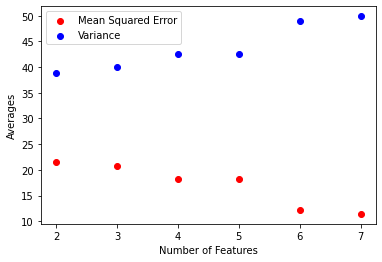

In [84]:
plt.scatter(*zip(*[*enumerate([two_mse, three_mse, four_mse, five_mse, six_mse, seven_mse], 2)]), color='red', label='Mean Squared Error')
plt.scatter(range(2,8), [two_var, three_var, four_var, five_var, six_var, seven_var], color='blue', label='Variance')
plt.xlabel('Number of Features')
plt.ylabel('Averages')
plt.legend()
plt.show()

## 7. Conclusion.

While the higher order multivariate models overfit in relation to the lower order multivariate models, the in-sample error and out-of-sample didn't deviate by much. The best model was around **50%** more accurate than the simplest model. On the other hand, the overall variance increased around **25%** as we increased the model complexity. This is a really good starting point, but your work is not done! The increased variance with the increased model complexity means that your model has more unpredictable performance on new, unseen data.

If you were working on this problem on a data science team, you'd need to confirm the predictive accuracy of the model using completely new, unobserved data (e.g. maybe from cars from later years). Since you can't wait until a model is deployed in the wild to know how well it works, the exploration we did in this lesson helps approximate a model's real-world performance.


### Exercise

## 8. Next Steps.

In this lesson, we explored overfitting at a deeper level and introduced related terminology that you'll see in other literature as well. So far, we've mostly dealt with supervised machine learning models to solve regression and classification problems. In the next lesson, we'll explore an **unsupervised machine learning** technique called k-means clustering.